In [20]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show columns with long strings
pd.set_option('display.max_colwidth', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [21]:
# today's date string for file naming automation
# today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
today_date_str = '_2024-05-29.csv'

print(today_date_str)

_2024-05-29.csv


In [22]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

590 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Industry,Sector,Exchange,Index,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Relative Volume at Time,Relative Volume 1 day,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",International Securities Identification Number,Relative Volume 1 day.1,Recent earnings date,Upcoming earnings date,Analyst Rating,Target price 1 year,Target price 1 year - Currency,Technical Rating 5 minutes
0,MRK,"Merck & Company, Inc.",Pharmaceuticals: Major,Health Technology,NYSE,"S&P 500, Dow Jones Industrial Average, S&P 500 Health Care, S&P 100, Russell 3000, Dow Jones Composite Average, Russell 1000, S&P 500 ESG, NYSE Arca Major Market",3.193615e+11,USD,126.09,USD,125.56,USD,0.53,USD,0.420335,-0.420335,2.529763e+09,10263383,10263383,300,6579231.1,7.011448e+06,7.951633e+06,2.982345,1.488591,1.417873,126.970000,140.365134,2.108415,1.638501,0.193841,0.393548,0.405137,4.086199,5.570945,3.706406,2.541509,1.424567,1.030642,1.719702,0.287895,0.783310,132.7900,USD,133.100,USD,133.100,USD,133.100,USD,133.10,USD,126.1700,USD,126.17,USD,126.17,USD,126.17,USD,126.17,USD,126.32,USD,129.08,USD,129.08,USD,132.7900,USD,8.315417e+05,USD,126.00300,126.013125,125.97834,125.984746,126.159105,125.964000,125.768895,126.165870,125.981335,125.796800,US58933Y1055,1.638501,2024-04-25,2024-07-30,Strong buy,144.115000,USD,Buy
1,CVX,Chevron Corporation,Integrated Oil,Energy Minerals,NYSE,"S&P 500, Dow Jones Industrial Average, S&P 500 Energy, S&P 100, Russell 3000, Dow Jones Composite Average, Russell 1000, S&P 500 ESG, NYSE Arca Major Market",2.931053e+11,USD,159.04,USD,159.20,USD,0.20,USD,0.125755,0.100604,1.842413e+09,6928298,6928298,2471,5851638.0,6.892064e+06,7.970841e+06,1.057297,1.118751,1.459606,158.803333,14.637424,1.171757,1.185614,0.513666,0.757822,1.106227,6.704452,6.384896,2.882033,2.787067,1.614468,0.844199,1.526835,0.196496,0.694946,167.1100,USD,167.110,USD,167.110,USD,171.700,USD,189.68,USD,159.3300,USD,159.35,USD,159.35,USD,159.35,USD,159.35,USD,159.35,USD,159.42,USD,159.42,USD,166.9100,USD,4.324934e+06,USD,158.93400,159.057500,159.20100,159.070138,159.442612,159.159000,158.875388,159.333391,158.970715,158.608039,US1667641005,1.185614,2024-04-26,2024-07-26,Buy,183.986364,USD,Buy
2,SHEL,Shell PLC,Integrated Oil,Energy Minerals,NYSE,NaN,2.247861e+11,USD,71.74,USD,72.09,USD,0.17,USD,0.236

In [23]:
#### CREATE MARKET CAP CATEGORIES ####
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans - 200 billion and above
        (df['Market capitalization'] >= 200000000000),
        # Large Cap - 10 billion to 200 billion
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),
        # Midlers - 2 billion to 10 billion
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),
        # Small Cap - 300 million to 2 billion
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000), 
        # Micro Cap - 50 million to 300 million
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),
        # Shrimp - 50 million and below
        (df['Market capitalization'] <= 50000000)
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df

In [24]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Industry,Sector,Exchange,Index,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Relative Volume at Time,Relative Volume 1 day,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",International Securities Identification Number,Relative Volume 1 day.1,Recent earnings date,Upcoming earnings date,Analyst Rating,Target price 1 year,Target price 1 year - Currency,Technical Rating 5 minutes,marketCapType
0,MRK,"Merck & Company, Inc.",Pharmaceuticals: Major,Health Technology,NYSE,"S&P 500, Dow Jones Industrial Average, S&P 500 Health Care, S&P 100, Russell 3000, Dow Jones Composite Average, Russell 1000, S&P 500 ESG, NYSE Arca Major Market",3.193615e+11,USD,126.09,USD,125.56,USD,0.53,USD,0.420335,-0.420335,2.529763e+09,10263383,10263383,300,6579231.1,7.011448e+06,7.951633e+06,2.982345,1.488591,1.417873,126.970000,140.365134,2.108415,1.638501,0.193841,0.393548,0.405137,4.086199,5.570945,3.706406,2.541509,1.424567,1.030642,1.719702,0.287895,0.783310,132.7900,USD,133.100,USD,133.100,USD,133.100,USD,133.10,USD,126.1700,USD,126.17,USD,126.17,USD,126.17,USD,126.17,USD,126.32,USD,129.08,USD,129.08,USD,132.7900,USD,8.315417e+05,USD,126.00300,126.013125,125.97834,125.984746,126.159105,125.964000,125.768895,126.165870,125.981335,125.796800,US58933Y1055,1.638501,2024-04-25,2024-07-30,Strong buy,144.115000,USD,Buy,Titans
1,CVX,Chevron Corporation,Integrated Oil,Energy Minerals,NYSE,"S&P 500, Dow Jones Industrial Average, S&P 500 Energy, S&P 100, Russell 3000, Dow Jones Composite Average, Russell 1000, S&P 500 ESG, NYSE Arca Major Market",2.931053e+11,USD,159.04,USD,159.20,USD,0.20,USD,0.125755,0.100604,1.842413e+09,6928298,6928298,2471,5851638.0,6.892064e+06,7.970841e+06,1.057297,1.118751,1.459606,158.803333,14.637424,1.171757,1.185614,0.513666,0.757822,1.106227,6.704452,6.384896,2.882033,2.787067,1.614468,0.844199,1.526835,0.196496,0.694946,167.1100,USD,167.110,USD,167.110,USD,171.700,USD,189.68,USD,159.3300,USD,159.35,USD,159.35,USD,159.35,USD,159.35,USD,159.35,USD,159.42,USD,159.42,USD,166.9100,USD,4.324934e+06,USD,158.93400,159.057500,159.20100,159.070138,159.442612,159.159000,158.875388,159.333391,158.970715,158.608039,US1667641005,1.185614,2024-04-26,2024-07-26,Buy,183.986364,USD,Buy,Titans
2,SHEL,Shell PLC,Integrated Oil,Energy Minerals,NYSE,NaN,2.247861e+11,USD,71.74,

In [25]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [26]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 590 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Shrimp,213,36.101695
1,Micro caps,155,26.271186
2,Small caps,110,18.644068
3,Midlers,58,9.830508
4,Large caps,46,7.796610
5,Titans,4,0.677966
6,Undefined,4,0.677966


In [27]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

100 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Industry,Sector,Exchange,Index,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Relative Volume at Time,Relative Volume 1 day,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 week,Relative Volume 1 month,Highest high 1 month,Highest high 1 month - Currency,Highest high 3 months,Highest high 3 months - Currency,Highest high 6 months,Highest high 6 months - Currency,Highest high 52 weeks,Highest high 52 weeks - Currency,Highest high All Time,Highest high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",International Securities Identification Number,Relative Volume 1 day.1,Recent earnings date,Upcoming earnings date,Analyst Rating,Target price 1 year,Target price 1 year - Currency,Technical Rating 5 minutes,marketCapType
38,MRO,Marathon Oil Corporation,Integrated Oil,Energy Minerals,NYSE,"S&P 500, S&P 500 Energy, Russell 3000, Russell 1000",1.491874e+10,USD,26.45,USD,27.29,USD,2.9200,USD,11.039698,3.175803,5.619508e+08,15046987,15046987,1702408,6952908.6,8.182915e+06,9.314440e+06,3.928433,2.286493,2.108633,26.243333,10.970097,2.377459,2.467733,0.364598,0.859028,2.228494,2.137746,3.999983,5.101112,4.270166,2.452136,1.641680,2.534079,0.355446,0.717520,27.9500,USD,30.0600,USD,30.0600,USD,30.0600,USD,42.2352,USD,26.55,USD,26.57,USD,26.57,USD,26.57,USD,26.57,USD,26.57,USD,26.570,USD,26.570,USD,27.4000,USD,3.811422e+06,USD,26.458,26.490625,26.478,26.410000,26.573549,26.483545,26.393541,26.517873,26.383065,26.248257,US5658491064,2.467733,2024-05-01,2024-07-31,Buy,34.148000,USD,Buy,Large caps
68,HALO,"Halozyme Therapeutics, Inc.",Biotechnology,Health Technology,NASDAQ,"NASDAQ Composite, Russell 2000, S&P MidCap 400, Russell 3000, NASDAQ Biotechnology, Mini-Russell 2000",5.482964e+09,USD,43.08,USD,43.00,USD,0.9200,USD,2.135562,-0.185701,1.258521e+08,1031547,1031547,400,1002216.6,9.525641e+05,1.082698e+06,2.986648,2.422450,3.097455,43.245000,17.817851,1.089228,1.042039,1.171941,1.095843,1.261183,2.993491,4.828795,4.682304,3.959400,2.150196,1.054962,1.393899,0.226496,0.923414,46.1599,USD,46.1599,USD,46.1599,USD,46.1599,USD,59.4600,USD,43.11,USD,43.20,USD,43.20,USD,43.20,USD,43.20,USD,43.35,USD,43.965,USD,43.965,USD,46.1599,USD,2.223198e+06,USD,43.015,43.053125,42.953,42.871500,43.184243,42.948250,42.712257,43.139926,42.913580,42.687234,US40637H1095,1.042039,2024-05-07,2024-08-06,Strong buy,50.250000,USD,Neutral,Midlers
16,ICE,Intercontinental Exchange Inc.,Investment Banks/Brokers,Finance,NYSE,"S&P 500, Russell 3000, S&P 500 Financials, Russell 1000, S&P 500 ESG",7.667678e+10,USD,133.68,USD,134.00,USD,1.0500,USD,0.785458,0.239378,5.687686e+08,1815510,1815510,200,1692435.6,2.101423e+06,2.326

In [28]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

print(tv_df.shape)

(100, 91)


In [29]:
market_info_df = tv_df['marketCapType'].value_counts().reset_index()
market_info_df.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
market_info_df['percentage'] = (market_info_df['count'] / market_info_df['count'].sum()) * 100

print(market_info_df.shape)
market_info_df

(6, 3)


,marketCapType,count,percentage
0,Large caps,30,30.0
1,Midlers,30,30.0
2,Small caps,26,26.0
3,Micro caps,8,8.0
4,Shrimp,4,4.0
5,Titans,2,2.0


In [30]:
# # 1/3 #### CONFIG DATA SECTION ####
# criteria_config = {
#     "Titans": {
#         "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
#         "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
#         "relative_volume_threshold": 1.2,  # Slightly more inclusive
#         "relative_volume_at_time_threshold": 0.03,  # More inclusive
#         "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
#         "pre_market_wmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
#     },
#     "Large caps": {
#         "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
#         "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
#         "relative_volume_threshold": 1.3,  # Slightly more inclusive
#         "relative_volume_at_time_threshold": 0.04,  # More inclusive
#         "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
#         "pre_market_vwap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
#     },
#     "Midlers": {
#         "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
#         "float_shares_outstanding_threshold": 50000000,  # 50 million shares
#         "relative_volume_threshold": 1.3,
#         "relative_volume_at_time_threshold": .05,
#         "pre_market_gap_percentage_threshold": .02,
#         "pre_market_vwap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
#     },
#     "Small caps": {
#         "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
#         "float_shares_outstanding_threshold": 20000000,  # 20 million shares
#         "relative_volume_threshold": 1.2,
#         "relative_volume_at_time_threshold": .05,
#         "pre_market_gap_percentage_threshold": .03,
#         "pre_market_vwap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
#     },
#     "Micro caps": {
#         "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
#         "float_shares_outstanding_threshold": 5000000,  # 5 million shares
#         "relative_volume_threshold": 1.1,
#         "relative_volume_at_time_threshold": .05,
#         "pre_market_gap_percentage_threshold": .04,
#         "pre_market_vwap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
#     },
#     "Shrimp": {
#         "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
#         "float_shares_outstanding_threshold": 1000000,  # 1 million shares
#         "relative_volume_threshold": 1.0,
#         "relative_volume_at_time_threshold": .05,
#         "pre_market_gap_percentage_threshold": .05,
#         "pre_market_vwap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
#     }
# }

# # 2/3 #### CORE FUNCTIONS ####
# def filter_by_pre_market_change(df, change_pct_threshold):
#     """Filter stocks by pre-market change percentage."""
#     return df[df['Pre-market Change %'] >= change_pct_threshold]

# def filter_by_float_shares(df, float_shares_threshold):
#     """Filter stocks by float shares outstanding."""
#     # create a copy to safely modify without affecting the original DataFrame
#     modified_df = df.copy()
#     modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
#     return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

# def filter_by_relative_volume(df, relative_volume_threshold):
#     """Filter stocks by relative volume."""
#     df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
#     return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

# def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
#     """Filter stocks by relative volume at a specific time."""
#     # Convert 'Relative Volume at Time' to float
#     df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
#     return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

# def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
#     """Filter stocks by pre-market gap percentage."""
#     return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

# def filter_by_price_near_vwap(df, pre_market_vwap_drawdown_threshold):
#     """
#     Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
#     """
#     df_filtered = df.copy()
#     df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
#     df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
#     # Calculate the acceptable minimum price based on the VWAP drawdown threshold
#     df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vwap_drawdown_threshold)
    
#     # Apply the filter
#     df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
#     return df_filtered.drop(columns=['Min Price from VWAP'])

# """SPECIAL FILTERS"""
# def filter_by_volatility(df):
#     """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
#     # Ensure data types are correct; convert to numeric if necessary
#     df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
#     df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
#     df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
#     filtered_df = df[
#         (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
#         (df['Volatility 1 day'] >= df['Volatility 1 month'])]
#     return filtered_df

# # 3/3 #### WRAPPER FUNCTION ####
# def screen_stocks_by_category(df, category):
#     """Screen stocks based on their market cap category."""
#     # 3a. Get the configuration for the specified category
#     config = criteria_config.get(category, {})
#     pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
#     float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
#     relative_volume_threshold = config.get("relative_volume_threshold", 0)
#     relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
#     pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
#     pre_market_vwap_drawdown_threshold = config.get("pre_market_vwap_drawdown_threshold", 0)
#     # 3b. Apply the filters
#     filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
#     filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
#     filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
#     filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
#     filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
#     # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
#     filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
#     filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vwap_drawdown_threshold)
  
#     # 3c. Return the filtered DataFrame
#     return filtered_df

In [31]:
# #EXECUTE
# tv_L2_df = pd.DataFrame()
# categories = tv_df['marketCapType'].unique()

# for category in categories:
#     category_df = tv_df[tv_df['marketCapType'] == category]
#     screened_df = screen_stocks_by_category(category_df, category)
#     tv_L2_df = pd.concat([tv_L2_df, screened_df])

# # Display results
# print(f'Original DataFrame length: {len(tv_df.index)}')
# print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
# print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# # filter in descending order by market cap and then by pre-market change percentage
# tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# # reset index and drop
# tv_L2_df = tv_L2_df.reset_index(drop=True)

In [32]:
# need to add error handling for when zero (0) return (4/4/24)
# zero again 5/24/24
# - not so much error handling but want to see if we need to adjust the criteria in general
# - need to put this theory and algo through more paper trading and adjust as needed

In [33]:
# # create a breakdown of the market cap types
# market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

# print('Returned Gap-Up Market Cap Type Groups:')
# market_cap_type_df3

In [34]:
# think about adding other staples to dataframe
# or you create a separate investments_long_df or similar for those, i.e., TSLA, PLTR, SOFI etc...

In [35]:
# # create a breakdown of the market cap types
# market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
# market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# # calculate percentage for each market cap type and add it to the DataFrame
# market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

# print('Returned Gap-Up Market Cap Type Groups:')
# market_cap_type_df3

# # market cap type groups
# print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

In [36]:
 # TradingView column names
# tv_raw_columns_list = tv_L2_df.columns.tolist()
# print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# # stocks returned from the pre-market gap up screener
# print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# # create a list of 'Symbols' from the tv_L2_df
# gap_up_stocks_list = tv_L2_df['Symbol']
# gap_up_stocks_list = gap_up_stocks_list.tolist()
# print(gap_up_stocks_list)

# # FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
# tv_L2_df

| FILTER CRITERIA CONFIG |
|-|
| TradingView (raw data) | 

things to add;
* Pre-Market Volume: Adding a minimum pre-market volume threshold can help filter out stocks that might have large percentage changes but low trading volumes, which can lead to unreliable price movements and high slippage.
Example: A minimum of 50,000 shares traded in the pre-market for all categories.

* overall market sentiment and filter tightener (macro)

In [37]:
#### CRITERIA CONFIG DICTIONARY ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # 1 billion shares
        "relative_volume_threshold": 1.2,  # More inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
        "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # 200 million shares
        "relative_volume_threshold": 1.3,  # More inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
        "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Mid caps": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.02,
        "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.03,
        "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.04,
        "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.05,
        "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
        #last
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    }
}

In [38]:
# what about exceptions, like if all these criteria above are met but there is super high volume and less than x& < 1% gap-up
# would have to specify specific criteria for the market caps

In [39]:
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    df.loc[:, 'Float shares outstanding'] = pd.to_numeric(df['Float shares outstanding'], errors='coerce')
    return df[df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df.loc[:, 'Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    df.loc[:, 'Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vwap_drawdown_threshold):
    """Filter stocks where the price is near the VWAP, considering the specified drawdown threshold."""
    df.loc[:, 'Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df.loc[:, 'Volume Weighted Average Price 1 day'] = pd.to_numeric(df['Volume Weighted Average Price 1 day'], errors='coerce')
    df.loc[:, 'Min Price from VWAP'] = df['Volume Weighted Average Price 1 day'] * (1 - pre_market_vwap_drawdown_threshold)
    return df[df['Price'] >= df['Min Price from VWAP']].drop(columns=['Min Price from VWAP'])

def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    df.loc[:, 'Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df.loc[:, 'Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df.loc[:, 'Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    return df[(df['Volatility 1 day'] >= df['Volatility 1 week']) & (df['Volatility 1 day'] >= df['Volatility 1 month'])]

#### last (i.e., stay organized, bookend filter section here, add other filters above ####
def filter_by_pre_market_volume(df, pre_market_volume_threshold):
    """Filter stocks by pre-market volume."""
    df['Pre-market Volume'] = pd.to_numeric(df['Pre-market Volume'], errors='coerce')
    return df[df['Pre-market Volume'] >= pre_market_volume_threshold]

In [40]:
# WRAPPER FUNCTION
def screen_stocks_by_category(df, category):
    # FILTERS
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vwap_drawdown_threshold = config.get("pre_market_vwap_drawdown_threshold", 0)
    # last
    pre_market_volume_threshold = config.get("pre_market_volume_threshold", 0)

    # FUNCTIONS (core processing)
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df)
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vwap_drawdown_threshold)
    # last
    filtered_df = filter_by_pre_market_volume(filtered_df, pre_market_volume_threshold)

    return filtered_df

In [41]:
#### EXECUTE AND CREATE FULL (baseline) GAP-UP DATAFRAME ####
gap_up_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    gap_up_stage_df = screen_stocks_by_category(category_df, category)
    gap_up_df = pd.concat([gap_up_df, gap_up_stage_df])

# filter in descending order by market cap and then by pre-market change percentage
gap_up_df = gap_up_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
gap_up_df.reset_index(drop=True, inplace=True)

# # display results
# print(f'Original dataFrame length: {len(tv_df.index)}')
# print(f'Number of rows removed: {len(tv_df.index) - len(gap_up_df.index)}')
# filter in descending order by market cap and then by pre-market change percentage
gap_up_df = gap_up_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# print(f'NEW (Gap-Up) dataFrame length: {len(gap_up_df.index)} (target stocks)')

# reset index and drop
gap_up_df.reset_index(drop=True, inplace=True)

## LOOK AT COLUMNS WHEN NEEDED
# print(gap_up_df.columns)
## all dataframe view
# gap_up_df

In [115]:
#### CREATE SIMPLE GAP-UP DATAFRAME ####
simple_cols_list = ['Symbol', 'Description', 'Pre-market Change %', 'Pre-market Gap %', 'marketCapType', 'Price', 'Pre-market Open', 'Industry', 'Index', 'Sector', 'Exchange']
simple_gap_df = gap_up_df[simple_cols_list]

print(simple_gap_df.columns)
print(simple_gap_df['Symbol'].unique())
print('\nSIMPLE GAP-UP DATAFRAME: contains target gap up stocks for TODAY') # fix this to dynamic
simple_gap_df 

Index(['Symbol', 'Description', 'Pre-market Change %', 'Pre-market Gap %',
       'marketCapType', 'Price', 'Pre-market Open', 'Industry', 'Index',
       'Sector', 'Exchange'],
      dtype='object')
['DKS' 'WFRD' 'CIVI' 'MGY' 'ALRM']

SIMPLE GAP-UP DATAFRAME: contains target gap up stocks for TODAY


,Symbol,Description,Pre-market Change %,Pre-market Gap %,marketCapType,Price,Pre-market Open,Industry,Index,Sector,Exchange
0,DKS,Dick's Sporting Goods Inc,10.205128,2.051282,Large caps,195.00,199.00,Specialty Stores,"S&P MidCap 400, Russell 3000, Russell 1000",Retail Trade,NYSE
1,WFRD,Weatherford International plc,0.380826,0.405663,Midlers,120.79,121.28,Oilfield Services/Equipment,"NASDAQ Composite, Russell 2000, S&P MidCap 400, Russell 3000, NASDAQ Industrials, Mini-Russell 2000, PHLX Oil Service Sector",Industrial Services,NASDAQ
2,CIVI,"Civitas Resources, Inc.",0.108844,0.108844,Midlers,73.50,73.58,Integrated Oil,"Russell 2000, S&P MidCap 400, Russell 3000, Mini-Russell 2000",Energy Minerals,NYSE
3,MGY,Magnolia Oil & Gas Corporation,0.157418,0.157418,Midlers,25.41,25.45,Oil & Gas Production,"Russell 2000, Russell 3000, Mini-Russell 2000",Energy Minerals,NYSE
4,ALRM,"Alarm.com Holdings, Inc.",0.238308,0.000000,Midlers,67.14,67.14,Packaged Software,"NASDAQ Composite, Russell 2000, Russell 3000, NASDAQ Computer, Mini-Russell 2000",Technology Services,NASDAQ


| Indexes |
|-|
| IEX Cloud API $ | 

market indexes, sector indexes
currencies???

In [43]:
#### STANDARD MARKET INDEXES EVALUATION
market_index_list = ['SPY', # SPX = S&P 500 index
                     'RSP', # SPXEW - S&P 500 equal weight index
                     'XLRE'] # real estate select sector SPDR fund

#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")  # Replace with your actual IEX API key

# Set the list of symbols variable
index_symbols = ','.join(market_index_list)

#### SET DATE RANGE HERE for - historical data processing
data_range = '5m' 

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={index_symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a DataFrame to collect data for each symbol
market_index_df = pd.DataFrame()

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(market_index_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'symbol' column to identify the data
            symbol_df['symbol'] = symbol
            # Append the current symbol's DataFrame to the main DataFrame
            market_index_df = pd.concat([market_index_df, symbol_df], ignore_index=True)
else:
    print(f'Failed to fetch data: {response.status_code}')

# Ensure date column is datetime format
market_index_df['date'] = pd.to_datetime(market_index_df['date'])

#### FILTER matching MANDATORY columns only
hist_data_mandatory_cols_list = ['symbol', 'date', 'close', 'high', 'low', 'open', 'volume']
market_index_df = market_index_df[hist_data_mandatory_cols_list]

# Sort by date descending and ticker order specified in the list
market_index_df['symbol'] = pd.Categorical(market_index_df['symbol'], categories=market_index_list, ordered=True)
market_index_df = market_index_df.sort_values(by=['date', 'symbol'], ascending=[False, True])
# Reset the index to get a numbered index
market_index_df = market_index_df.reset_index(drop=True)
# rename the new index (these are DAYS aka trading periods since today if sorted descending)
# market_index_df.index.name = 'INDEX'

# print(market_index_df.columns)

# # view df
# market_index_df

Processing symbols: 100%|██████████| 3/3 [00:00<00:00, 717.18it/s]


In [44]:
# Set variables for historical data analysis
mi_length = len(market_index_df.index)
unique_stocks = market_index_df['symbol'].nunique()
start_date = market_index_df['date'].min()
end_date = market_index_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{market_index_df["date"].nunique()} days of historical stock data.\n')
print(f"{mi_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = mi_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {market_index_list}')
index_cols_list = market_index_df.columns.tolist()
print(f'Columns: {index_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

print('INDEX DATAFRAME: historical price data $')
# Display the first few rows of the dataframe
market_index_df.tail(10)

START date: 2024-01-02 00:00:00
END date: 2024-05-30 00:00:00
104 days of historical stock data.

312 = Length of dataframe
3 = Unique stocks in dataframe
104.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['SPY', 'RSP', 'XLRE']
Columns: ['symbol', 'date', 'close', 'high', 'low', 'open', 'volume']
INDEX DATAFRAME:


,symbol,date,close,high,low,open,volume
302,XLRE,2024-01-05,39.29,39.630,38.9179,39.15,5770315
303,SPY,2024-01-04,467.28,470.960,467.0500,468.30,84232169
304,RSP,2024-01-04,155.26,156.290,155.1950,155.46,5621643
305,XLRE,2024-01-04,39.37,39.660,39.2350,39.39,7180365
306,SPY,2024-01-03,468.79,471.190,468.1700,470.43,103585866
307,RSP,2024-01-03,155.52,156.980,155.3000,156.98,9207475
308,XLRE,2024-01-03,39.47,40.130,39.3950,40.13,7424653
309,SPY,2024-01-02,472.65,473.670,470.4900,472.16,123007793
310,RSP,2024-01-02,157.85,158.345,156.7700,157.02,9816475
311,XLRE,2024-01-02,40.43,40.450,39.7800,39.97,6591505


| MARKET SENTIMENT | 
|-|

In [45]:
#### MARKET SENTIMENT
# 1 - VIX (Volatility Index): A high VIX can indicate market uncertainty, making it essential to manage risk carefully.
# 2 - Overall Market Trend: Align your trades with the overall market trend. If major indices are bullish, it supports a positive trading environment.
# 2i - see CRAMER
# 2ii - see CRAMER
# 2iii - see CRAMER
# 3 - maybe some CRAMER + your own adaptation(s)
# 4 - Index match and performance
# 5 - sector index match on performance
# 6 - how do i deal with implied volatility, do i overlay, is there  pre-built metric (if so how is that calculated)
# 7 - further VIX and other adjustments, how to deal with implied volatility, at the macro and specific stock level / sector level and whatever is in between

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [46]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [ ]:
"""THIS IS WHERE YOU HAVE TO START AND DO WORK, maybe move up to organize better"""

In [47]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [50]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stock_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stock_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 5/5 [00:00<00:00, 739.42it/s]


In [51]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stock_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.tail(10)

START date: 2024-01-02
END date: 2024-05-30
104 days of historical stock data.

520 = Length of dataframe
5 = Unique stocks in dataframe
104.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['DKS', 'WFRD', 'CIVI', 'MGY', 'ALRM']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
510,69.66,70.59,69.08,69.81,2024-05-16,ALRM,100417,HISTORICAL_PRICES,ALRM,,2024-05-16,1.715934e+12,0.098565,0.098565,69.81,69.66,70.59,69.08,100417,69.81,69.66,70.59,69.08,100417,"May 16, 24",-0.39,-0.0056,ALRM
511,69.04,69.83,68.23,69.82,2024-05-17,ALRM,116756,HISTORICAL_PRICES,ALRM,,2024-05-17,1.716020e+12,0.088787,0.088787,69.82,69.04,69.83,68.23,116756,69.82,69.04,69.83,68.23,116756,"May 17, 24",-0.62,-0.0089,ALRM
512,68.89,69.53,68.51,68.85,2024-05-20,ALRM,100061,HISTORICAL_PRICES,ALRM,,2024-05-20,1.716280e+12,0.086422,0.086422,68.85,68.89,69.53,68.51,100061,68.85,68.89,69.53,68.51,100061,"May 20, 24",-0.15,-0.0022,ALRM
513,68.67,69.10,68.50,68.69,2024-05-21,ALRM,82022,HISTORICAL_PRICES,ALRM,,2024-05-21,1.716366e+12,0.082952,0.082952,68.69,68.67,69.10,68.50,82022,68.69,68.67,69.10,68.50,82022,"May 21, 24",-0.22,-0.0032,ALRM
514,67.02,68.79,66.84,68.53,2024-05-22,ALRM,92566,HISTORICAL_PRICES,ALRM,,2024-05-22,1.716452e+12,0.056931,0.056931,68.53,67.02,68.79,66.84,92566,68.53,67.02,68.79,66.84,92566,"May 22, 24",-1.65,-0.0240,ALRM
515,67.41,67.88,66.35,67.07,2024-05-23,ALRM,99924,HISTORICAL_PRICES,ALRM,,2024-05-23,1.716542e+12,0.063082,0.063082,67.07,67.41,67.88,66.35,99924,67.07,67.41,67.88,66.35,99924,"May 23, 24",0.39,0.0058,ALRM
516,67.11,67.78,66.87,67.78,2024-05-24,ALRM,101877,HISTORICAL_PRICES,ALRM,,2024-05-24,1.716625e+12,0.058350,0.058350,67.78,67.11,67.78,66.87,101877,67.78,67.11,67.78,66.87,101877,"May 24, 24",-0.30,-0.0045,ALRM
517,67.14,67.80,65.23,66.10,2024-05-28,ALRM,216995,HISTORICAL_PRICES,ALRM,,2024-05-28,1.716971e+12,0.058824,0.058824,66.10,67.14,67.80,65.23,216995,66.10,67.14,67.80,65.23,216995,"May 28, 24",0.03,0.0004,ALRM
518,66.36,67.43,66.17,67.26,2024-05-29,ALRM,271809,HISTORICAL_PRICES,ALRM,,2024-05-29,1.717057e+12,0.046523,0.046523,67.26,66.36,67.43,66.17,271809,67.26,66.36,67.43,66.17,271809,"May 29, 24",-0.78,-0.0116,ALRM
519,66.09,66.88,65.61,66.36,2024-05-30,ALRM,189714,HISTORICAL_PRICES,ALRM,,2024-05-30,1.717144e+12,0.042265,0.042265,66.36,66.09,66.88,65.61,189714,66.36,66.09,66.88,65.61,189714,"May 30, 24",-0.27,-0.0041,ALRM


In [52]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [53]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,ALRM,2024-05-30,66.09,66.88,65.61,66.36,189714
1,CIVI,2024-05-30,72.59,73.68,72.40,72.86,743306
2,DKS,2024-05-30,224.16,228.50,220.53,227.28,2356740
3,MGY,2024-05-30,25.46,25.63,25.20,25.20,1394035
4,WFRD,2024-05-30,118.64,121.12,117.96,117.96,191137


In [54]:
# re-index the dataframe
# chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 520


In [55]:
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.

In [ ]:
"""END DEV FRIDAY"""

| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [56]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()
# think about returning unique values first row 
# you wont get today if b/c of no close price obviously

,symbol,date,close,high,low,open,volume
0,DKS,2024-01-02,146.00,148.0400,144.86,145.81,920742
416,ALRM,2024-01-02,63.41,64.2800,62.62,64.02,309597
104,WFRD,2024-01-02,95.28,99.7699,94.83,99.09,553967
312,MGY,2024-01-02,21.49,21.8900,21.32,21.42,2019420
208,CIVI,2024-01-02,68.08,69.9200,67.68,69.10,771376


| HISTORICAL DATA |
|-|
| Baselne Data: OHCLV (Open, High, Low, Close, Volume) Candlestick Chart |
| IMPORTANT: For effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). |

In [57]:
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

print(chart_historical_df.index.dtype)  # Should print 'datetime64[ns]'
print(chart_historical_df.columns)  # This will list all columns except 'date'
chart_historical_df.head()


datetime64[ns]
Index(['symbol', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


,symbol,close,high,low,open,volume
date,,,,,,
2024-01-02,DKS,146.00,148.0400,144.86,145.81,920742
2024-01-02,ALRM,63.41,64.2800,62.62,64.02,309597
2024-01-02,WFRD,95.28,99.7699,94.83,99.09,553967
2024-01-02,MGY,21.49,21.8900,21.32,21.42,2019420
2024-01-02,CIVI,68.08,69.9200,67.68,69.10,771376


# TREND LINES - UNIT TESTING

| TICKER - Unit TESTING | 
|-|

In [58]:
#### dynamic symbol test update 
# return the unique symbols and store as list
unique_symbols = chart_historical_df['symbol'].unique()
unique_symbols_list = unique_symbols.tolist()

print(unique_symbols_list)

ex_ticker = unique_symbols_list[0]

print(ex_ticker)

['DKS', 'ALRM', 'WFRD', 'MGY', 'CIVI']
DKS


In [59]:
# #### HARDCODED SYMBOL -> Option #1
# ticker = 'CRM'
# ticker_df = chart_historical_df[chart_historical_df['symbol'] == ticker].copy()

#### DYNAMIC SYMBOL (allocation) -> Option #2
ticker = ex_ticker
ticker_df = chart_historical_df[chart_historical_df['symbol'] == ex_ticker].copy()

ticker_df.head()

,symbol,close,high,low,open,volume
date,,,,,,
2024-01-02,DKS,146.00,148.04,144.860,145.81,920742
2024-01-03,DKS,138.85,144.52,138.760,144.16,1314023
2024-01-04,DKS,138.52,139.84,137.060,137.90,1302246
2024-01-05,DKS,138.93,141.93,138.360,138.36,812523
2024-01-08,DKS,139.85,140.49,138.035,139.78,1042699


In [60]:
# rename columns so they are capitalized for mplfinance specs
ticker_df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-05-16,DKS,196.92,200.90,196.84,200.23,679396
2024-05-17,DKS,194.54,197.12,192.38,196.93,890391
2024-05-20,DKS,193.73,196.68,193.39,195.25,806773
2024-05-21,DKS,188.51,194.17,187.90,193.98,1070808
2024-05-22,DKS,183.74,188.17,182.84,188.09,1108452
2024-05-23,DKS,186.60,188.04,185.08,185.44,958078
2024-05-24,DKS,189.97,191.26,187.61,187.61,894243
2024-05-28,DKS,195.00,195.78,191.45,191.94,2280820
2024-05-29,DKS,226.03,229.56,212.30,212.97,5103329


In [61]:
# save unit test dataframe to csv
ticker_df.to_csv(f'unit_TEST/historical_data_{ticker}{today_date_str}.csv', index=True)

# ADVANCED WIP

In [62]:
ticker_df.head(6)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-01-02,DKS,146.00,148.04,144.860,145.81,920742
2024-01-03,DKS,138.85,144.52,138.760,144.16,1314023
2024-01-04,DKS,138.52,139.84,137.060,137.90,1302246
2024-01-05,DKS,138.93,141.93,138.360,138.36,812523
2024-01-08,DKS,139.85,140.49,138.035,139.78,1042699
2024-01-09,DKS,141.03,142.11,138.355,139.07,1169680


| ADVANCED CHARTING | 
|-|
| Trend Lines | 

In [63]:
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative value if invalid 
    
    intercept = -slope * pivot + y.iloc[pivot]  # Using .iloc[] for positional indexing
    line_vals = slope * np.arange(len(y)) + intercept  # Calculate line values
    diffs = line_vals - y  # Calculate differences between line values and actual values
    
    if support and diffs.max() > 1e-5:
        return -1.0  # Line is not valid for support
    elif not support and diffs.min() < -1e-5:
        return -1.0  # Line is not valid for resistance
    
    err = (diffs ** 2.0).sum()  # Calculate sum of squared errors
    return err

def optimize_slope(support: bool, pivot: int, init_slope: float, y: np.array):
    slope_unit = (y.max() - y.min()) / len(y)  # Determine the unit change for slope
    
    # Initialize optimization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    
    assert(best_err >= 0.0)  # Initial slope should not produce an error
    
    get_derivative = True
    derivative = None
    while curr_step > min_step:
        if get_derivative:
            # Numerical differentiation to find the direction to adjust slope
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err

            if test_err < 0.0:  # If increasing slope fails, try decreasing
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0:  # If derivative failed, abort optimization
                raise Exception("Derivative failed. Check your data.")

            get_derivative = False

        if derivative > 0.0:  # If increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else:  # If increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        
        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err:  # If slope failed or didn't reduce error
            curr_step *= 0.5  # Reduce step size
        else:  # If test slope reduced error
            best_err = test_err
            best_slope = test_slope
            get_derivative = True  # Recompute derivative
    
    return (best_slope, -best_slope * pivot + y.iloc[pivot])  # Using .iloc[] for positional indexing

def fit_trendlines_single(data: np.array):
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line
    
    # Find pivot points
    upper_pivot = (data - line_points).argmax()
    lower_pivot = (data - line_points).argmin()
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs)

def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)  # Fit line of best fit
    line_points = coefs[0] * x + coefs[1]  # Get points of line

    # Find pivot points
    upper_pivot = (high - line_points).argmax()
    lower_pivot = (low - line_points).argmin()
    
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)


In [64]:
# should be based on 72 periods but displayed as 24 periods maybe? nah?

In [65]:
# step 1: fit trendlines for each stock
support_coefs, resist_coefs = fit_trendlines_high_low(ticker_df['High'], ticker_df['Low'], ticker_df['Close'])

In [66]:
# step 2: calculate trendlines
x_values = np.arange(len(ticker_df))  # Use the actual data range

# Calculate the line values using the coefficients
support_line = support_coefs[0] * x_values + support_coefs[1]
resistance_line = resist_coefs[0] * x_values + resist_coefs[1]

| ADVANCED CHARTING |
|-|
| Line of Best Fit (Regression Line) |
| Pivot point Xs |
| CLOSE |

In [67]:
# linear regresion
last_72_df = ticker_df.iloc[-72:]
X = np.arange(len(last_72_df)).reshape(-1, 1)
y = last_72_df['Close'].values.reshape(-1, 1)

model = LinearRegression().fit(X, y)
best_fit_last_72 = model.predict(X).flatten()

# Preparing the regression line plot data
best_fit_series = pd.Series([np.nan] * len(ticker_df))
best_fit_series.iloc[-72:] = best_fit_last_72


In [68]:
# # Identify the pivot points within the last 72 periods
# pivot_point_low_index = last_72_df['Close'].idxmin()
# pivot_point_high_index = last_72_df['Close'].idxmax()

In [69]:
# # Initialize series for pivot points with NaN values
# pivot_points_high_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)
# pivot_points_low_series = pd.Series(data=[np.nan] * len(ticker_df), index=ticker_df.index)

# # Set the pivot point values
# pivot_points_high_series[pivot_point_high_index] = ticker_df.loc[pivot_point_high_index, 'Close']
# pivot_points_low_series[pivot_point_low_index] = ticker_df.loc[pivot_point_low_index, 'Close']

| ADVANCED CHARTING |
|-|
| Extending the trend and regression lines to the future |

In [70]:
# # Extend x_values for future predictions
# future_line_periods = 10
# current_periods = len(ticker_df)
# extended_x_values = np.arange(current_periods + future_line_periods)

# # Calculate extended trend lines
# extended_support_line = support_coefs[0] * extended_x_values + support_coefs[1]
# extended_resistance_line = resist_coefs[0] * extended_x_values + resist_coefs[1]

# # Calculate extended line of best fit
# X_future = np.arange(-72, future_line_periods).reshape(-1, 1)  # -72 for last 72 periods and future periods
# extended_best_fit = model.predict(X_future).flatten()

| ADVANCED CHARTING - CHART IT |
|-|
| Candlestick Chart (KEY Levels overlayed) |


In [71]:
# prepare the plot
apds = [mpf.make_addplot(support_line, color='green', width=2),
        mpf.make_addplot(resistance_line, color='red', width=2),
        mpf.make_addplot(best_fit_series, color='orange', width=2)]        
        # mpf.make_addplot(pivot_points_high_series, type='scatter', markersize=100, marker='x', color='green'),
        # mpf.make_addplot(pivot_points_low_series, type='scatter', markersize=100, marker='x', color='red')]

In [72]:
# look at the df
ticker_df.tail(10)

# youre going to have to create some placeholders here.
# another df?

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-05-16,DKS,196.92,200.90,196.84,200.23,679396
2024-05-17,DKS,194.54,197.12,192.38,196.93,890391
2024-05-20,DKS,193.73,196.68,193.39,195.25,806773
2024-05-21,DKS,188.51,194.17,187.90,193.98,1070808
2024-05-22,DKS,183.74,188.17,182.84,188.09,1108452
2024-05-23,DKS,186.60,188.04,185.08,185.44,958078
2024-05-24,DKS,189.97,191.26,187.61,187.61,894243
2024-05-28,DKS,195.00,195.78,191.45,191.94,2280820
2024-05-29,DKS,226.03,229.56,212.30,212.97,5103329


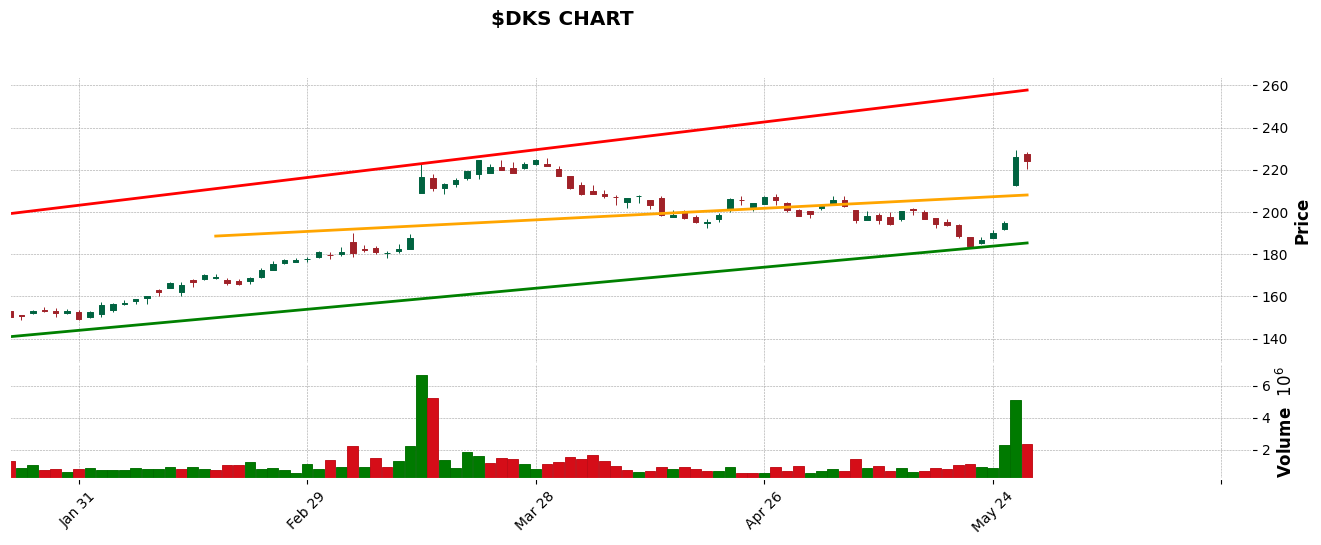

In [73]:
#### CHART IT ####
# Define the period for the x-axis view and future extension
lookback_periods = 90
future_periods = 20

# Calculate the extended index for the lookback period
lookback_index = ticker_df.index[-lookback_periods]

# Generate the future index by adding the future periods to the last date
future_index = pd.date_range(start=ticker_df.index[-1] + pd.Timedelta(days=1),
                             periods=future_periods, freq='B')

# Combine the current and future indices
full_index = ticker_df.index.union(future_index)

# Set the xlim for plotting
xlim = (lookback_index, full_index[-1])

# Plot the candlestick chart with extended x-axis
mpf.plot(ticker_df,
         type='candle',
         style='charles',
         volume=True,
         title=f'${ticker} CHART',
         figratio=(42, 14),
         xlim=xlim,  # Set the new x-axis limits
         addplot=apds)  # 'apds' should contain all your additional plots

In [74]:
ticker_df.tail(10)

,symbol,Close,High,Low,Open,Volume
date,,,,,,
2024-05-16,DKS,196.92,200.90,196.84,200.23,679396
2024-05-17,DKS,194.54,197.12,192.38,196.93,890391
2024-05-20,DKS,193.73,196.68,193.39,195.25,806773
2024-05-21,DKS,188.51,194.17,187.90,193.98,1070808
2024-05-22,DKS,183.74,188.17,182.84,188.09,1108452
2024-05-23,DKS,186.60,188.04,185.08,185.44,958078
2024-05-24,DKS,189.97,191.26,187.61,187.61,894243
2024-05-28,DKS,195.00,195.78,191.45,191.94,2280820
2024-05-29,DKS,226.03,229.56,212.30,212.97,5103329


In [75]:
support_line

array([133.94308391, 134.44203204, 134.94098016, 135.43992828,
       135.93887641, 136.43782453, 136.93677265, 137.43572078,
       137.9346689 , 138.43361702, 138.93256515, 139.43151327,
       139.93046139, 140.42940952, 140.92835764, 141.42730576,
       141.92625389, 142.42520201, 142.92415013, 143.42309826,
       143.92204638, 144.4209945 , 144.91994263, 145.41889075,
       145.91783887, 146.416787  , 146.91573512, 147.41468324,
       147.91363137, 148.41257949, 148.91152761, 149.41047574,
       149.90942386, 150.40837198, 150.90732011, 151.40626823,
       151.90521635, 152.40416448, 152.9031126 , 153.40206072,
       153.90100885, 154.39995697, 154.89890509, 155.39785322,
       155.89680134, 156.39574946, 156.89469759, 157.39364571,
       157.89259383, 158.39154196, 158.89049008, 159.3894382 ,
       159.88838633, 160.38733445, 160.88628257, 161.3852307 ,
       161.88417882, 162.38312694, 162.88207507, 163.38102319,
       163.87997131, 164.37891944, 164.87786756, 165.37

# END ADVANCED WIP TESTS

| DATA PACKAGE |
|-|
| Trend Lines |


In [76]:
# # Step 3: Calculate the y-values for the line of best fit for the last 72 periods
# best_fit_last_72 = model.predict(X)

# # Create a series for the best fit line, filled with NaN except for the last 72 values
# best_fit_series = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # best_fit_series = pd.Series(model.predict(X), index=last_72_df.index)
# best_fit_series[-72:] = best_fit_last_72

# # # Step 4: Pivot Points
# # pivot_point_low_index = last_72_df['Close'].idxmin()
# # pivot_point_low_value = last_72_df.loc[pivot_point_low_index, 'Close']

# # pivot_point_high_index = last_72_df['Close'].idxmax()
# # pivot_point_high_value = last_72_df.loc[pivot_point_high_index, 'Close']

# # # Create a series for the pivot points, similar to the best fit line
# # pivot_points_low = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_low[pivot_point_low_index] = pivot_point_low_value

# # pivot_points_high = pd.Series([np.nan] * len(ticker_df), index=ticker_df.index)
# # pivot_points_high[pivot_point_high_index] = pivot_point_high_value

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()


# # # step 5: chart setup
# # apds = [
# #     mpf.make_addplot(best_fit_series, color='orange', width=2),
# #     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
# #     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# # ]

# # # Step X: chart it
# # last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# # mpf.plot(ticker_df,
# #          type='candle',
# #          style='charles',
# #          volume=True,
# #          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
# #          figratio=(42, 14),
# #          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
# #          addplot=apds)

# # mpf.show()

In [77]:
# # step 5: chart setup
# apds = [
#     mpf.make_addplot(best_fit_series, color='orange', width=2),
#     mpf.make_addplot(pivot_points_low, type='scatter', markersize=200, marker='x', color='red'),
#     mpf.make_addplot(pivot_points_high, type='scatter', markersize=200, marker='x', color='green')  # Green X for the highest point
# ]

In [78]:
# # Step X: chart it
# last_72_index = ticker_df.index[-90] # 90 periods on the x-axis

# mpf.plot(ticker_df,
#          type='candle',
#          style='charles',
#          volume=True,
#          title=f'{ticker} Candlestick Chart: Last 72 Periods with Regression Line and Pivot Point',
#          figratio=(42, 14),
#          xlim=(last_72_index, ticker_df.index[-1]),  # Adjusted for the last 72 periods
#          addplot=apds)

# mpf.show()


50DSMA - needed bc everyone has it
standard deviations (2 above)
63DMA - makes at least more sense (63 trading days in a quarter)
2dVWAP
3dVWAP
AVWAP

| Dataframe -> .csv file |
|-|

In [79]:
# # create a csv file with a flat date index (otherwise it'll get lost when saving to csv)
# ticker_csv_df = ticker_df.reset_index()
# # dtype of date
# print(ticker_csv_df['date'].dtype)
# # print index type
# print(ticker_csv_df.index.dtype)

# # save to csv
# ticker_csv_df.to_csv(f'{ticker}_historical_data{today_date_str}', index=False)

# ticker_csv_df.head(2)


In [80]:
# #### add VWAP to df
# chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

# chart_historical_df.head(4)

In [81]:
# """SIMPLE MOVING AVERAGES (SMA)"""
# def calculate_sma(dataframe, period):
#     return dataframe['close'].rolling(window=period).mean()

# chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
# chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
# chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

# chart_historical_df.tail(10)


In [82]:
# """EXPONENTIAL MOVING AVERAGES (EMA)"""
# def calculate_ema(dataframe, period):
#     return dataframe['close'].ewm(span=period, adjust=False).mean()

# # calculate EMAs for the specified periods
# chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
# chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
# chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
# chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

# chart_historical_df.tail(10)


In [83]:
# """MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# # calculate the MACD line and the Signal line
# chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
# chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# # MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
# chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

# chart_historical_df.tail(10)

In [84]:
# #### DEV - DATA ORGANIZATION ####
# chart_historical_df.columns

In [85]:
# """BOLLINGER BANDS (BB)"""
# # BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
# period = 20 # SMA periods
# std_dev_multiplier = 2 # standard deviation multiplier

# # line 1: middle band -> simple moving average (SMA)
# chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# # not a line: standard deviation -> used to calculate the upper and lower bands
# chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# # lines 2 & 3: upper and lower bands
# chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# # BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
# chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# # Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
# chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# # Calculate the standard deviation of the Typical Price
# chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# # Calculate the upper and lower bands for the Typical Price and name them accordingly
# chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
# chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# # view df with new (2) BBs (6 new columns)
# # chart_historical_df.iloc[-1] # last row slice to check the new columns
# chart_historical_df.tail(2)


In [86]:
# chart_historical_df.head(5)

In [87]:
# # drop rows that contain NAs (pulled extra data earlier for this purpose)
# chart_historical_df = chart_historical_df.dropna()

# # view the df
# chart_historical_df.head(5)

In [88]:
# # date column check data type
# chart_historical_df.index

In [89]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [90]:
# chart_historical_df.index

In [91]:
# chart_historical_df.head(5)

In [92]:
# print(tv_L2_df.columns)

In [93]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [94]:
# """RELATIVE STRENGTH INDEX (RSI)"""
# def calculate_rsi(dataframe, periods=14):
#     close_delta = dataframe['close'].diff()
#     up = close_delta.clip(lower=0)
#     down = -1 * close_delta.clip(upper=0)

#     ma_up = up.rolling(window=periods).mean()
#     ma_down = down.rolling(window=periods).mean()

#     rsi = ma_up / (ma_up + ma_down) * 100
#     return rsi

# # Adding the RSI to your DataFrame
# chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

# chart_historical_df.tail(10)


In [95]:
# """AVERAGE TRUE RANGE (ATR)"""
# def calculate_atr(dataframe, period=14):
#     high_low = dataframe['high'] - dataframe['low']
#     high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
#     low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

#     # Calculate the True Range (TR) as the maximum of the three measures
#     tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

#     # Calculate the ATR by taking the rolling mean of the TR
#     atr = tr.rolling(window=period).mean()
    
#     return atr

# # Adding the ATR to your DataFrame
# chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

# chart_historical_df.tail(10)

In [96]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [97]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [98]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [99]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [100]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [101]:
# # AVAILABLE COLS
# chart_historical_df.columns

In [102]:
# def plot_symbol_technicals(chart_historical_df, symbol):
#     # FILTER
#     symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
#     # print(symbol_df.head(5))
#     # DATA PREP
#     add2plot = [
#         # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
#         # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
#         mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
#     ]
    
#     # STYLE & PLOT
#     mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
#     fig, axes = mpf.plot(symbol_df,
#                          type='candle',
#                          addplot=add2plot,
#                          volume=True,
#                          style=mpf_style,
#                         #  style='yahoo',
#                          figratio=(42, 12),
#                          title=f'${symbol} - Historical Data (4 Months)',
#                          tight_layout=True,
#                          returnfig=True)

#     # watermark
#     fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

#     mpf.show()


In [103]:
# # print a list of the unique stock symbols
# unique_symbols = chart_historical_df['symbol'].unique()
# print(f'Unique stock symbols: {unique_symbols}')

In [104]:
# #### EXECUTE CHARTING ####
# # DEV
# plot_symbol_technicals(chart_historical_df, 'GRND')

# # # PRO
# # for unique in unique_symbols:
# #     plot_symbol_technicals(chart_historical_df, unique)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [105]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [106]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [107]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [108]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [109]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [110]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [111]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [112]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)